# Graph Classification
#### Graham Trogdon and Akshay Iyengar

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 #installed with pip install opencv-python
import albumentations #for image processing. install with pip install albumentations
from torch.utils.data import Dataset
from torch.utils.data import random_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

import os

TESTING_SET_PERCENTAGE=0.3 #Make testing set 30% of total dataset

cwd = os.path.abspath(os.getcwd())
dataset_dir = "graphs"

dataset_files = os.listdir(dataset_dir)

In [3]:
class Graphs(Dataset):
    def __init__(self, dir_path, file_list, transform=None):
        self.dir_path = dir_path
        self.file_list = file_list
        self.transform = transform
        self.label_dict = {'just_image' : 0, 'bar_chart' : 1, 'diagram' : 2, 
                           'flow_chart' : 3, 'graph' : 4, 'growth_chart' : 5,
                           'pie_chart' : 6, 'table' : 7}

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.dir_path, self.file_list[idx])
        
        if image_name.split('.')[::-1][0] == "gif":
            gif = cv2.VideoCapture(image_name)
            _, image = gif.read()
        else:
            image = cv2.imread(image_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        for name, label in self.label_dict.items():
            if name in image_name.split('/')[::-1][0]:
                self.label = label
                break

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.label
    
img_size = 224

data_transforms = albumentations.Compose([albumentations.Resize(img_size, img_size)])
dataset = Graphs(cwd+'/'+dataset_dir+'/', dataset_files, transform=data_transforms)

In [4]:
#Perform random split in data to partition training and testing data
test_size = int(len(dataset) * TESTING_SET_PERCENTAGE) 
train_set, test_set = random_split(dataset, 
                                  (len(dataset_files)-test_size, test_size))

In [5]:
train_images, train_labels = map(list, zip(*[(X, y) for X, y in iter(train_set)]))

test_images, test_labels = map(list, zip(*[(X, y) for X, y in iter(test_set)]))

# Exploring the Data

### Line Graph
No. of samples in each set

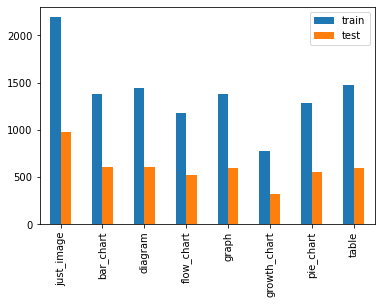

In [6]:
class_names = ['just_image', 'bar_chart', 'diagram', 'flow_chart', 'graph',
               'growth_chart', 'pie_chart', 'table']

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts, 'test': test_counts},
             index=class_names).plot.bar()
plt.show()

# Pie Chart
Breakdown of labels of each image

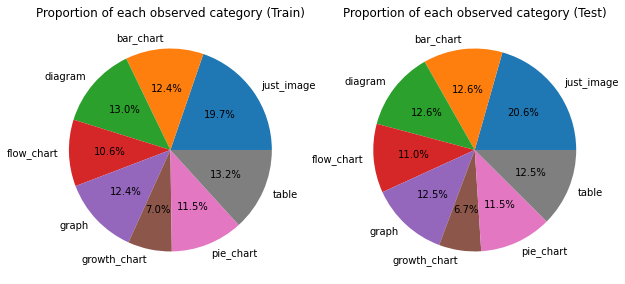

In [7]:
# plot pie chart to observe proportion of classes in dataset
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.pie(train_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0) , 
        labels=class_names, autopct='%1.1f%%')
ax1.set_title('Proportion of each observed category (Train)')

ax2.pie(test_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0) , 
        labels=class_names, autopct='%1.1f%%')
ax2.set_title('Proportion of each observed category (Test)')

plt.show()

# Image Samples
Sample of Images

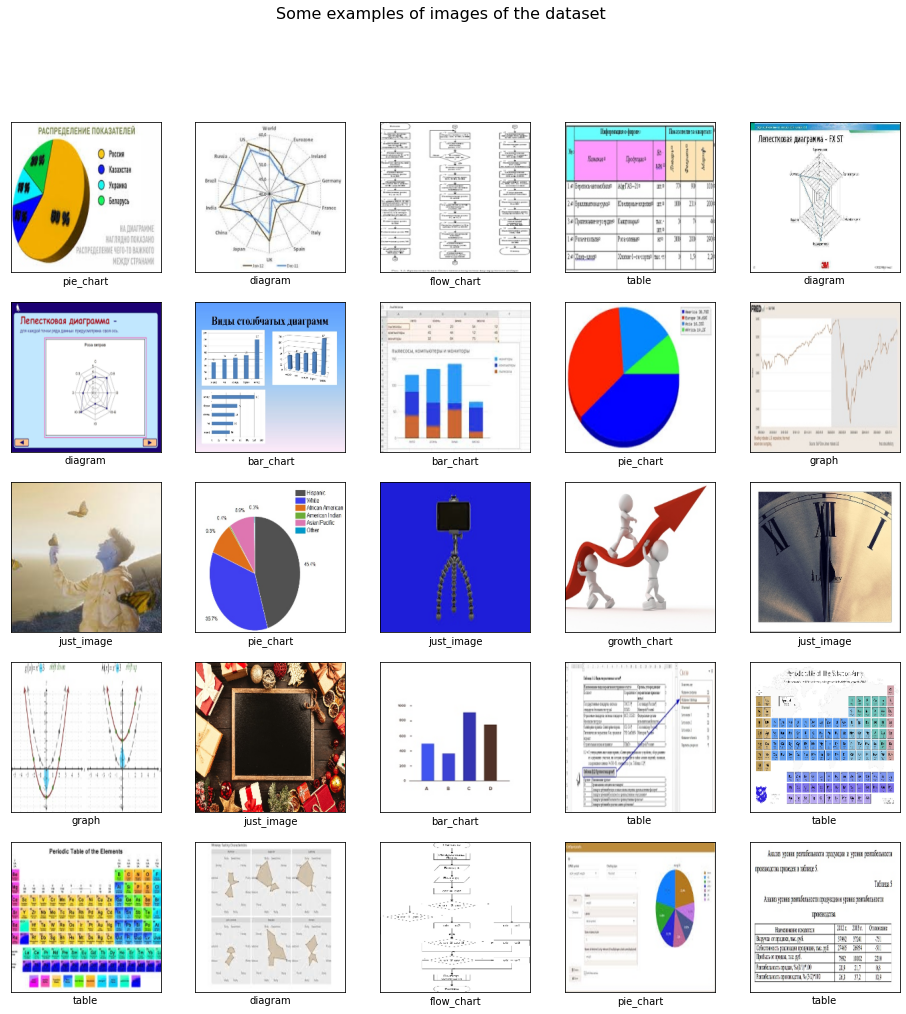

In [8]:
fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Stage 1: Training
Let's try to see if we can distinguish between regular images (0) and any other kind of graphic (1-7)
with a logistic regression.

Let's reshape the train image data to fit in a logistic regression model.
We'll do that by greyscaling the image (average style) and then flattening.

In [9]:
train_image_shape = np.shape(train_images)
grey_scale = np.zeros((train_image_shape[0], train_image_shape[1] * train_image_shape[2]))
grey_scale_labels = np.array(train_labels)>0

for i in range(len(train_set)):
    asArr = np.array(train_images[i])
    grey_scale[i] = np.ndarray.flatten(np.mean(asArr, axis=2, dtype=int))

print("done")

done


Time to create the model and train it.
Warning: It may take a hot second.

In [10]:
first_model = LogisticRegression()
first_model.fit(grey_scale[-500:], grey_scale_labels[-500:])
print("done!")

done!


/usr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We'll need to do the same greyscale and flattening modification as above for the testing data

In [11]:
test_image_shape = np.shape(test_images)
grey_scale_testing = np.zeros((test_image_shape[0], test_image_shape[1] * test_image_shape[2]))
grey_scale_labels_testing = np.array(test_labels)>0

for i in range(len(test_set)):
    asArr = np.array(test_images[i])
    grey_scale_testing[i] = np.ndarray.flatten(np.mean(asArr, axis=2, dtype=int))

print("done")

done


Testing time!

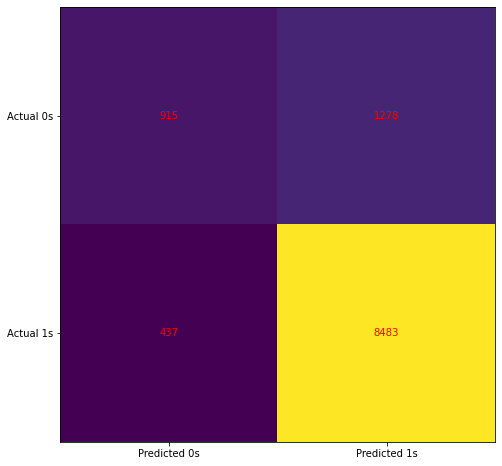

In [12]:
first_model.score(grey_scale_testing, grey_scale_labels_testing)

b = confusion_matrix(grey_scale_labels, first_model.predict(grey_scale))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(b)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, b[i, j], ha='center', va='center', color='red')
plt.show()

80% is pretty solid for this very naive approach!
The results are better than I was expecting.